<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/11XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core libraries
import yfinance as yf
import pandas as pd
import numpy as np

# Preprocessing and train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use XGBoost instead of SVM/KNN
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()

/tmp/ipython-input-3287618951.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [3]:
train_df = df.loc["2013-01-01":"2023-12-31"]
test_df  = df.loc["2024-01-01":"2024-12-31"]

X_train = train_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_train = train_df['Target']

X_test = test_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_test = test_df['Target']


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [5]:
xgb_model = XGBClassifier(
    n_estimators=300,        # number of boosting rounds
    learning_rate=0.05,      # step size shrinkage
    max_depth=5,             # tree depth
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:45:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.5060240963855421

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.64      0.55       115
           1       0.56      0.39      0.46       134

    accuracy                           0.51       249
   macro avg       0.52      0.52      0.50       249
weighted avg       0.52      0.51      0.50       249



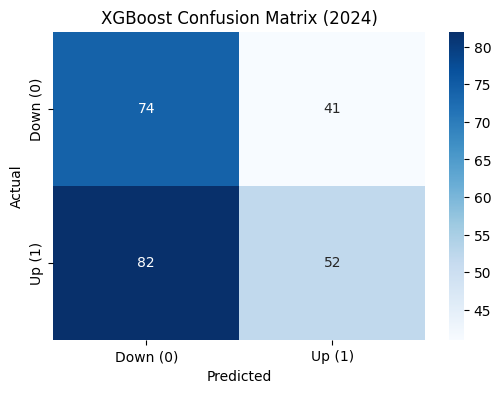

In [6]:
y_pred = xgb_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix (2024)")
plt.show()


# new

In [7]:
# Core
import yfinance as yf
import pandas as pd
import numpy as np

# Preprocessing & splits
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# XGBoost
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# Download 10 years of Gold Fields data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep OHLCV
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create binary target: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (no target available)
df = df.dropna()

# Winsorize Volume to reduce extreme outliers (top 1%)
df['Volume'] = np.where(df['Volume'] > df['Volume'].quantile(0.99),
                        df['Volume'].quantile(0.99),
                        df['Volume'])


/tmp/ipython-input-1344406379.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [9]:
train_df = df.loc["2013-01-01":"2023-12-31"]
test_df  = df.loc["2024-01-01":"2024-12-31"]

X_train = train_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_train = train_df['Target']

X_test = test_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_test = test_df['Target']


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [11]:
# Compute scale_pos_weight = (#negative / #positive)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("Class 0:", neg, "Class 1:", pos, "Scale_pos_weight:", scale_pos_weight)


Class 0: 1446 Class 1: 1353 Scale_pos_weight: 1.0687361419068737


In [12]:
# Base model
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

# Hyperparameter space
param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0.5, 1, 2],
    'reg_alpha': [0, 0.5, 1]
}

# TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # number of random parameter samples
    scoring='accuracy',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train)

print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Best CV score: 0.515450643776824


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:51:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [18]:
from packaging import version
import xgboost as xgb

if version.parse(xgb.__version__) >= version.parse("2.0.0"):
    # New API
    best_xgb = XGBClassifier(
        **search.best_params_,
        random_state=42,
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        early_stopping_rounds=30
    )
    best_xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
else:
    # Old API
    best_xgb = XGBClassifier(
        **search.best_params_,
        random_state=42,
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss"
    )
    best_xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds=30, verbose=False)


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [10:54:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Accuracy: 0.43373493975903615

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.87      0.59       115
           1       0.35      0.06      0.10       134

    accuracy                           0.43       249
   macro avg       0.40      0.46      0.34       249
weighted avg       0.39      0.43      0.33       249



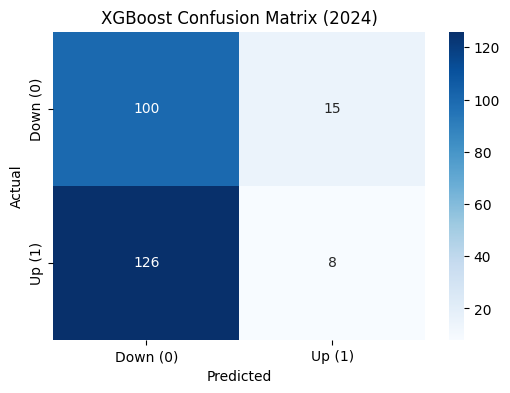

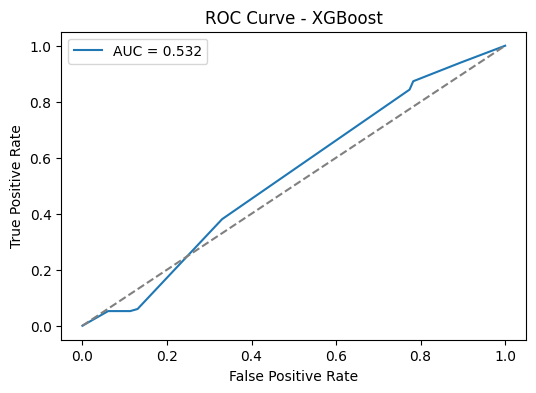

In [19]:
y_pred = best_xgb.predict(X_test_scaled)
y_proba = best_xgb.predict_proba(X_test_scaled)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix (2024)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()


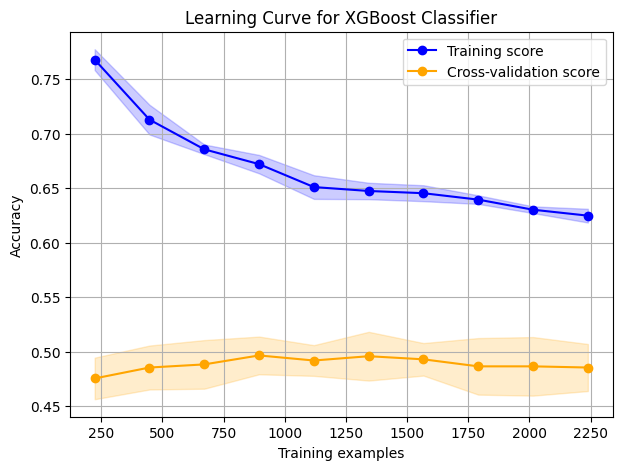

In [20]:
from sklearn.model_selection import learning_curve

# Define XGB model with your best params
xgb_model = XGBClassifier(
    **search.best_params_,
    random_state=42,
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss"
)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model,
    X_train_scaled, y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Mean & std
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="orange", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve for XGBoost Classifier")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()
